In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Rio Grande Do Norte - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_RN.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio Grande do Norte - IDH Longevidade,Rio Grande Do Norte - Consumo de Cimento (t),Rio Grande do Norte - IDH Renda,Rio Grande do Norte - IDH,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,Rio Grande do Norte - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.793473,36.825,0.631207,0.689488,9944.060800,1.853436,1006.950610,8770.488958,26.531232,21.591412,74.870205,5.667138,1.843384e+06,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170,0.629167,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.793993,34.088,0.631578,0.689892,10034.559262,1.852423,1006.950925,8770.488958,26.531261,21.591907,74.872429,5.663569,1.855573e+06,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224,0.629592,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.794514,30.150,0.631948,0.690297,10120.152965,1.851832,1006.951108,8770.488958,26.531278,21.592195,74.873726,5.661487,1.867763e+06,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278,0.630017,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.795034,31.224,0.632319,0.690702,10199.169751,1.851769,1006.951128,8770.488958,26.531280,21.592226,74.873865,5.661264,1.879953e+06,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332,0.630443,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.795555,33.606,0.632689,0.691107,10272.393199,1.893568,1006.815853,8100.094916,26.560194,21.749605,75.499649,5.413625,1.892142e+06,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387,0.630868,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


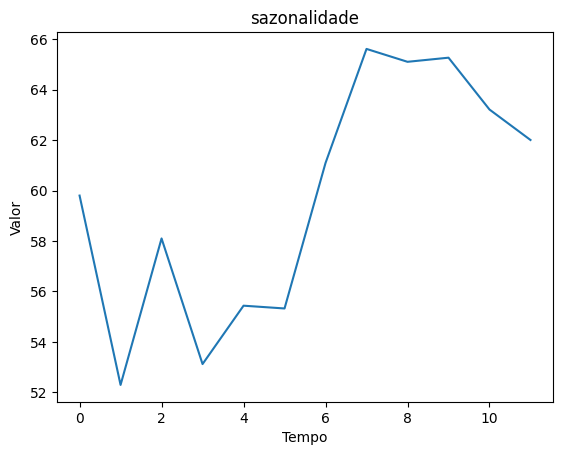

,sazonalidade
sazonalidade,
0,59.798725
1,52.289793
2,58.098576
3,53.116962
4,55.432047
5,55.321868
6,61.091975
7,65.614959
8,65.103883


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio Grande do Norte - IDH Longevidade,Rio Grande do Norte - IDH Renda,Rio Grande do Norte - IDH,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,Rio Grande do Norte - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Rio Grande Do Norte - Consumo de Cimento (t)
0,2003-1,0.793473,0.631207,0.689488,9944.060800,1.853436,1006.950610,8770.488958,26.531232,21.591412,74.870205,5.667138,1.843384e+06,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170,0.629167,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,59.798725,36.825
1,2003-2,0.793993,0.631578,0.689892,10034.559262,1.852423,1006.950925,8770.488958,26.531261,21.591907,74.872429,5.663569,1.855573e+06,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224,0.629592,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,52.289793,34.088
2,2003-3,0.794514,0.631948,0.690297,10120.152965,1.851832,1006.951108,8770.488958,26.531278,21.592195,74.873726,5.661487,1.867763e+06,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278,0.630017,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,58.098576,30.150
3,2003-4,0.795034,0.632319,0.690702,10199.169751,1.851769,1006.951128,8770.488958,26.531280,21.592226,74.873865,5.661264,1.879953e+06,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332,0.630443,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,53.116962,31.224
4,2003-5,0.795555,0.632689,0.691107,10272.393199,1.893568,1006.815853,8100.094916,26.560194,21.749605,75.499649,5.413625,1.892142e+06,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387,0.630868,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,55.432047,33.606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.432047,NaN
245,2023-6,NaN,NaN,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.321868,NaN
246,2023-7,NaN,NaN,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.091975,NaN
247,2023-8,NaN,NaN,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.614959,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      38.146
1      30.350
2      33.791
3      30.891
4      30.724
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Rio Grande Do Norte - Consumo de Cimento (t), Length: 249, dtype: float64

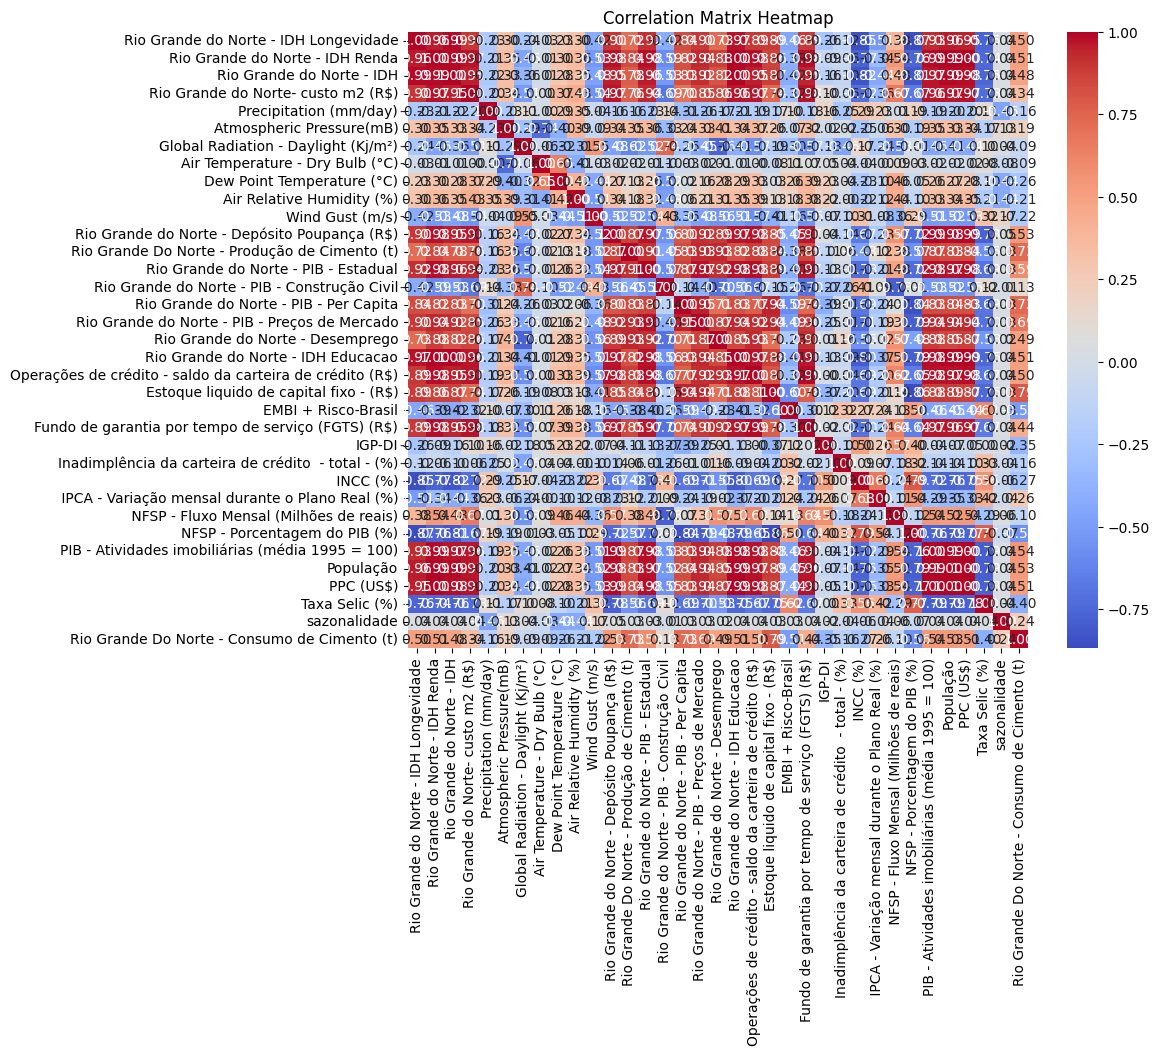

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rio Grande do Norte - IDH Longevidade,5.126909e+08
1,Rio Grande do Norte - IDH Renda,2.896555e+08
2,Rio Grande do Norte - IDH,3.718075e+09
3,Rio Grande do Norte- custo m2 (R$),1.586692e+06
4,Precipitation (mm/day),6.456645e+01
5,Atmospheric Pressure(mB),3.961800e+07
6,Global Radiation - Daylight (Kj/m²),1.117424e+02
7,Air Temperature - Dry Bulb (°C),1.235137e+07
8,Dew Point Temperature (°C),9.032565e+06
9,Air Relative Humidity (%),4.854186e+06


In [39]:
# data = data.drop(['Global Radiation - Daylight (Kj/m²)',
#                  'sazonalidade'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


,Rio Grande do Norte - IDH Longevidade,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,0.793473,9944.060800,1.853436,8770.488958,21.591412,74.870205,5.667138,1.843384e+06,27.698760,3.164847e+07,1.998664e+06,8.294170,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,59.798725
1,0.793993,10034.559262,1.852423,8770.488958,21.591907,74.872429,5.663569,1.855573e+06,27.407645,3.168897e+07,2.001107e+06,8.288224,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,52.289793
2,0.794514,10120.152965,1.851832,8770.488958,21.592195,74.873726,5.661487,1.867763e+06,27.377422,3.172947e+07,2.003550e+06,8.282278,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,58.098576
3,0.795034,10199.169751,1.851769,8770.488958,21.592226,74.873865,5.661264,1.879953e+06,27.542280,3.176997e+07,2.005994e+06,8.276332,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,53.116962
4,0.795555,10272.393199,1.893568,8100.094916,21.749605,75.499649,5.413625,1.892142e+06,27.944900,3.181046e+07,2.008437e+06,8.270387,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,55.432047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.829624,25198.273978,1.200523,1569.841101,21.894896,77.820138,4.261302,4.526375e+06,84.315875,3.694077e+07,1.968192e+06,12.990369,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,65.614959
200,0.829442,25374.248816,1.255936,1649.437187,21.964327,76.692954,4.340809,4.592933e+06,85.078035,3.689866e+07,1.969046e+06,12.983957,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,65.103883
201,0.829259,25558.432434,1.548844,1686.360791,22.202683,76.228637,4.262391,4.659490e+06,86.047192,3.685655e+07,1.969899e+06,12.977546,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,65.267355
202,0.829076,25749.144058,1.984800,1695.915090,22.591752,76.436450,4.107739,4.726048e+06,86.835757,3.681444e+07,1.970752e+06,12.971135,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,63.211432


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.549632,0.380987,0.061742,-0.500631,-0.526252,1.015966,-1.739421,-1.242001,-1.795453,-0.676831,-0.937135,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-1.529261,0.378913,0.061742,-0.499792,-0.525284,1.012260,-1.723649,-1.251396,-1.775188,-0.628618,-0.939550,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-1.509995,0.377703,0.061742,-0.499303,-0.524719,1.010098,-1.707876,-1.252371,-1.754923,-0.580404,-0.941964,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-1.492208,0.377573,0.061742,-0.499250,-0.524659,1.009867,-1.692103,-1.247051,-1.734658,-0.532191,-0.944379,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-1.475726,0.463126,-0.017595,-0.232283,-0.252217,0.752685,-1.676330,-1.234057,-1.714393,-0.483978,-0.946794,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.884020,-0.955368,-0.790407,0.014179,0.758032,-0.444041,1.732237,0.585211,0.852766,-1.278134,0.970023,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268
200,1.923631,-0.841952,-0.780988,0.131958,0.267301,-0.361470,1.818359,0.609809,0.831694,-1.261296,0.967420,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925
201,1.965090,-0.242439,-0.776618,0.536289,0.065155,-0.442909,1.904481,0.641086,0.810622,-1.244458,0.964816,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663
202,2.008018,0.649857,-0.775487,1.196280,0.155629,-0.603520,1.990603,0.666536,0.789550,-1.227620,0.962213,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.549632,0.380987,0.061742,-0.500631,-0.526252,1.015966,-1.739421,-1.242001,-1.795453,-0.676831,-0.937135,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-1.529261,0.378913,0.061742,-0.499792,-0.525284,1.012260,-1.723649,-1.251396,-1.775188,-0.628618,-0.939550,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-1.509995,0.377703,0.061742,-0.499303,-0.524719,1.010098,-1.707876,-1.252371,-1.754923,-0.580404,-0.941964,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-1.492208,0.377573,0.061742,-0.499250,-0.524659,1.009867,-1.692103,-1.247051,-1.734658,-0.532191,-0.944379,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-1.475726,0.463126,-0.017595,-0.232283,-0.252217,0.752685,-1.676330,-1.234057,-1.714393,-0.483978,-0.946794,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.558767,-1.404608,-0.789675,-0.236482,0.516412,-0.274294,1.127948,0.363544,1.053105,-1.451496,0.991216,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820
188,1.577774,-1.337614,-0.790259,0.076574,0.194733,-0.257757,1.128235,0.372723,1.042537,-1.440397,0.990623,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503
189,1.597766,-1.425992,-0.792486,0.498717,-0.050077,-0.309065,1.128522,0.389517,1.031970,-1.429298,0.990029,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444
190,1.618228,-0.834980,-0.800089,1.144811,0.219934,-0.478904,1.128809,0.404684,1.021403,-1.418199,0.989436,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      38.146
1      30.350
2      33.791
3      30.891
4      30.724
        ...  
187    72.189
188    71.920
189    72.544
190    70.478
191    71.370
Name: Rio Grande Do Norte - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 23)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
156,0.858648,-0.490749,-0.781003,1.915583,0.694789,-0.738302,0.674791,1.083194,1.130575,-1.305446,1.163228,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265
157,0.880002,-0.089545,-0.783266,2.032532,0.909429,-0.713430,0.692039,1.033930,1.134535,-1.324043,1.152019,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084
158,0.902470,0.126577,-0.792129,1.901860,1.223343,-0.786514,0.709288,0.987139,1.138495,-1.342641,1.140809,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087
159,0.925187,-0.169259,-0.800586,1.369527,1.369251,-0.725196,0.726536,0.943063,1.142455,-1.361238,1.129599,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300
160,0.948519,-0.161579,-0.799144,0.618800,1.205203,-0.647471,0.743784,0.893255,1.146415,-1.379835,1.118390,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403
161,0.971651,-0.625295,-0.794230,-0.022067,0.848590,-0.442721,0.761032,0.861129,1.150375,-1.398433,1.107180,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434
162,0.996138,-0.840891,-0.785791,-0.391269,0.385226,-0.212828,0.778280,0.831883,1.154335,-1.417030,1.095970,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553
163,1.021262,-0.862760,-0.778010,-0.391530,0.018246,-0.084189,0.795528,0.807183,1.158295,-1.435628,1.084760,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038
164,1.045964,-0.823773,-0.775601,-0.133082,-0.229647,-0.028945,0.812776,0.781661,1.162255,-1.454225,1.073551,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412
165,1.071387,-0.635419,-0.775023,0.205914,-0.338880,-0.047918,0.830024,0.759885,1.166215,-1.472823,1.062341,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 23)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(104, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1531427629, 660920378, 934015805, 3513319100, 3765825331, 4146198198, 2310432129, 3888074628, 4058480834, 2186239109]


Step: 0 ___________________________________________
val_loss: 65.35588836669922
winner_seed: 1531427629


Step: 1 ___________________________________________
val_loss: 112.97687530517578


Step: 2 ___________________________________________
val_loss: 55.259090423583984
winner_seed: 934015805


Step: 3 ___________________________________________
val_loss: 52.72306823730469
winner_seed: 3513319100


Step: 4 ___________________________________________
val_loss: 93.24413299560547


Step: 5 ___________________________________________
val_loss: 113.17725372314453


Step: 6 ___________________________________________
val_loss: 41.484073638916016
winner_seed: 2310432129


Step: 7 ___________________________________________
val_loss: 68.65540313720703


Step: 8 ___________________________________________
val_loss: 16.737916946411133
winner_seed: 4058480834


Step: 9 _________

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2652417522

Epoch 1/10000
5/5 [==============================] - 2s 91ms/step - loss: 3155.2139 - val_loss: 145.3978
Epoch 2/10000
5/5 [==============================] - 0s 8ms/step - loss: 247.0210 - val_loss: 148.4572
Epoch 3/10000
5/5 [==============================] - 0s 9ms/step - loss: 217.8429 - val_loss: 118.7806
Epoch 4/10000
5/5 [==============================] - 0s 8ms/step - loss: 218.3058 - val_loss: 5266.6372
Epoch 5/10000
5/5 [==============================] - 0s 8ms/step - loss: 166.1620 - val_loss: 149.2362
Epoch 6/10000
5/5 [==============================] - 0s 8ms/step - loss: 127.3325 - val_loss: 409.3076
Epoch 7/10000
5/5 [==============================] - 0s 8ms/step - loss: 154.1255 - val_loss: 124.2505
Epoch 8/10000
5/5 [==============================] - 0s 8ms/step - loss: 95.5577 - val_loss: 386.1830
Epoch 9/10000
5/5 [==============================] - 0s 8ms/step - loss: 65.6228 - val_loss: 208.3971
Epoch 10/10000
5/5 [==============================] - 0s 7ms/step - loss

5/5 [==============================] - 0s 7ms/step - loss: 23.8308 - val_loss: 85.4631
Epoch 81/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.0866 - val_loss: 98.9461
Epoch 82/10000
5/5 [==============================] - 0s 7ms/step - loss: 25.2999 - val_loss: 103.3126
Epoch 83/10000
5/5 [==============================] - 0s 7ms/step - loss: 22.3810 - val_loss: 81.0720
Epoch 84/10000
5/5 [==============================] - 0s 8ms/step - loss: 26.2660 - val_loss: 116.8916
Epoch 85/10000
5/5 [==============================] - 0s 8ms/step - loss: 22.3984 - val_loss: 101.8348
Epoch 86/10000
5/5 [==============================] - 0s 7ms/step - loss: 25.0033 - val_loss: 141.0580
Epoch 87/10000
5/5 [==============================] - 0s 7ms/step - loss: 25.8768 - val_loss: 91.2964
Epoch 88/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.5207 - val_loss: 131.4178
Epoch 89/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.3118 - val_loss

5/5 [==============================] - 0s 7ms/step - loss: 21.1200 - val_loss: 106.2062
Epoch 160/10000
5/5 [==============================] - 0s 7ms/step - loss: 22.3305 - val_loss: 170.5612
Epoch 161/10000
5/5 [==============================] - 0s 7ms/step - loss: 29.1375 - val_loss: 90.0585
Epoch 162/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.9648 - val_loss: 116.7150
Epoch 163/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.1612 - val_loss: 94.2928
Epoch 164/10000
5/5 [==============================] - 0s 7ms/step - loss: 25.1279 - val_loss: 93.7428
Epoch 165/10000
5/5 [==============================] - 0s 6ms/step - loss: 20.1096 - val_loss: 91.8429
Epoch 166/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.3373 - val_loss: 95.6171
Epoch 167/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.2048 - val_loss: 87.8726
Epoch 168/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.1982 - v

5/5 [==============================] - 0s 6ms/step - loss: 19.3322 - val_loss: 91.6513
Epoch 239/10000
5/5 [==============================] - 0s 6ms/step - loss: 17.6257 - val_loss: 88.5729
Epoch 240/10000
5/5 [==============================] - 0s 6ms/step - loss: 17.1820 - val_loss: 93.3991
Epoch 241/10000
5/5 [==============================] - 0s 6ms/step - loss: 17.7605 - val_loss: 96.8013
Epoch 242/10000
5/5 [==============================] - 0s 6ms/step - loss: 19.1194 - val_loss: 98.4137
Epoch 243/10000
5/5 [==============================] - 0s 6ms/step - loss: 16.9543 - val_loss: 78.9513
Epoch 244/10000
5/5 [==============================] - 0s 6ms/step - loss: 19.2421 - val_loss: 101.4407
Epoch 245/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.0503 - val_loss: 88.9808
Epoch 246/10000
5/5 [==============================] - 0s 6ms/step - loss: 16.5214 - val_loss: 88.1785
Epoch 247/10000
5/5 [==============================] - 0s 6ms/step - loss: 18.7215 - val

5/5 [==============================] - 0s 6ms/step - loss: 18.1554 - val_loss: 113.3792
Epoch 318/10000
5/5 [==============================] - 0s 6ms/step - loss: 18.8909 - val_loss: 116.4623
Epoch 319/10000
5/5 [==============================] - 0s 6ms/step - loss: 17.2926 - val_loss: 101.2332
Epoch 320/10000
5/5 [==============================] - 0s 6ms/step - loss: 16.6998 - val_loss: 111.2056
Epoch 321/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.0417 - val_loss: 103.1591
Epoch 322/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.9202 - val_loss: 113.7849
Epoch 323/10000
5/5 [==============================] - 0s 6ms/step - loss: 16.9688 - val_loss: 123.6543
Epoch 324/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.1908 - val_loss: 108.1705
Epoch 325/10000
5/5 [==============================] - 0s 6ms/step - loss: 17.1770 - val_loss: 113.5463
Epoch 326/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.53

5/5 [==============================] - 0s 6ms/step - loss: 18.3410 - val_loss: 109.9437
Epoch 397/10000
5/5 [==============================] - 0s 6ms/step - loss: 17.2312 - val_loss: 123.9662
Epoch 398/10000
5/5 [==============================] - 0s 6ms/step - loss: 16.2100 - val_loss: 109.6745
Epoch 399/10000
5/5 [==============================] - 0s 6ms/step - loss: 16.7597 - val_loss: 114.7970
Epoch 400/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.5984 - val_loss: 112.1018
Epoch 401/10000
5/5 [==============================] - 0s 7ms/step - loss: 15.5798 - val_loss: 115.5439
Epoch 402/10000
5/5 [==============================] - 0s 7ms/step - loss: 15.3123 - val_loss: 106.3947
Epoch 403/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.2939 - val_loss: 112.8236
Epoch 404/10000
5/5 [==============================] - 0s 6ms/step - loss: 17.1408 - val_loss: 113.7950
Epoch 405/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.26

Epoch 475/10000
5/5 [==============================] - 0s 6ms/step - loss: 17.2374 - val_loss: 97.5435
Epoch 476/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.1353 - val_loss: 100.0659
Epoch 477/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.5062 - val_loss: 115.5029
Epoch 478/10000
5/5 [==============================] - 0s 6ms/step - loss: 17.0137 - val_loss: 111.2271
Epoch 479/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.5902 - val_loss: 108.9058
Epoch 480/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.1407 - val_loss: 105.6592
Epoch 481/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.2209 - val_loss: 116.0738
Epoch 482/10000
5/5 [==============================] - 0s 7ms/step - loss: 15.6814 - val_loss: 110.6845
Epoch 483/10000
5/5 [==============================] - 0s 6ms/step - loss: 16.4214 - val_loss: 115.6957
Epoch 484/10000
5/5 [==============================] - 0s 6ms/ste

Epoch 554/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.1853 - val_loss: 118.5779
Epoch 555/10000
5/5 [==============================] - 0s 6ms/step - loss: 16.1670 - val_loss: 130.1646
Epoch 556/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.2923 - val_loss: 125.0539
Epoch 557/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.1524 - val_loss: 77.2992
Epoch 558/10000
5/5 [==============================] - 0s 6ms/step - loss: 18.1260 - val_loss: 80.7334
Epoch 559/10000
5/5 [==============================] - 0s 7ms/step - loss: 14.4539 - val_loss: 103.8804
Epoch 560/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.6670 - val_loss: 97.4141
Epoch 561/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.3071 - val_loss: 119.2010
Epoch 562/10000
5/5 [==============================] - 0s 7ms/step - loss: 15.2500 - val_loss: 123.7244
Epoch 563/10000
5/5 [==============================] - 0s 7ms/step 

5/5 [==============================] - 0s 6ms/step - loss: 13.0382 - val_loss: 109.4031
Epoch 634/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.5109 - val_loss: 76.0204
Epoch 635/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.3195 - val_loss: 111.4090
Epoch 636/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.0767 - val_loss: 105.1428
Epoch 637/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.8831 - val_loss: 105.1265
Epoch 638/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.7668 - val_loss: 111.4324
Epoch 639/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.8351 - val_loss: 113.0628
Epoch 640/10000
5/5 [==============================] - 0s 7ms/step - loss: 14.4818 - val_loss: 116.0704
Epoch 641/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.8117 - val_loss: 95.2468
Epoch 642/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.1083

5/5 [==============================] - 0s 6ms/step - loss: 13.0264 - val_loss: 80.5867
Epoch 713/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.6590 - val_loss: 93.5526
Epoch 714/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.5344 - val_loss: 130.5669
Epoch 715/10000
5/5 [==============================] - 0s 6ms/step - loss: 18.2014 - val_loss: 114.9077
Epoch 716/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.0243 - val_loss: 109.6468
Epoch 717/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.8849 - val_loss: 104.1410
Epoch 718/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.2238 - val_loss: 109.5154
Epoch 719/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.0912 - val_loss: 115.2231
Epoch 720/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.2154 - val_loss: 113.3085
Epoch 721/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.2086

5/5 [==============================] - 0s 6ms/step - loss: 15.5262 - val_loss: 122.1986
Epoch 792/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.8849 - val_loss: 124.8704
Epoch 793/10000
5/5 [==============================] - 0s 6ms/step - loss: 12.7028 - val_loss: 101.6346
Epoch 794/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.5811 - val_loss: 108.6901
Epoch 795/10000
5/5 [==============================] - 0s 7ms/step - loss: 15.1704 - val_loss: 109.4927
Epoch 796/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.9669 - val_loss: 110.9309
Epoch 797/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.3500 - val_loss: 126.0421
Epoch 798/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.1996 - val_loss: 94.6468
Epoch 799/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.4627 - val_loss: 122.0165
Epoch 800/10000
5/5 [==============================] - 0s 8ms/step - loss: 14.080

5/5 [==============================] - 0s 6ms/step - loss: 14.3144 - val_loss: 97.7383
Epoch 871/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.9302 - val_loss: 67.7158
Epoch 872/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.6353 - val_loss: 50.6809
Epoch 873/10000
5/5 [==============================] - 0s 6ms/step - loss: 12.9665 - val_loss: 84.9303
Epoch 874/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.9879 - val_loss: 95.5204
Epoch 875/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.4060 - val_loss: 85.4546
Epoch 876/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.8781 - val_loss: 46.9201
Epoch 877/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.3821 - val_loss: 100.1755
Epoch 878/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.1211 - val_loss: 46.9449
Epoch 879/10000
5/5 [==============================] - 0s 6ms/step - loss: 12.6525 - val

5/5 [==============================] - 0s 6ms/step - loss: 13.9825 - val_loss: 54.6963
Epoch 950/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.9533 - val_loss: 48.8197
Epoch 951/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.1692 - val_loss: 55.0908
Epoch 952/10000
5/5 [==============================] - 0s 6ms/step - loss: 11.7461 - val_loss: 51.9477
Epoch 953/10000
5/5 [==============================] - 0s 6ms/step - loss: 12.7632 - val_loss: 46.5762
Epoch 954/10000
5/5 [==============================] - 0s 6ms/step - loss: 12.5528 - val_loss: 97.8972
Epoch 955/10000
5/5 [==============================] - 0s 6ms/step - loss: 12.1727 - val_loss: 83.7366
Epoch 956/10000
5/5 [==============================] - 0s 6ms/step - loss: 11.4987 - val_loss: 62.5831
Epoch 957/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.1934 - val_loss: 56.8724
Epoch 958/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.5548 - val_

5/5 [==============================] - 0s 7ms/step - loss: 12.5547 - val_loss: 79.9885
Epoch 1029/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.0412 - val_loss: 43.2571
Epoch 1030/10000
5/5 [==============================] - 0s 7ms/step - loss: 13.1692 - val_loss: 39.5031
Epoch 1031/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.7072 - val_loss: 78.6060
Epoch 1032/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.1110 - val_loss: 44.9333
Epoch 1033/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.8655 - val_loss: 51.0455
Epoch 1034/10000
5/5 [==============================] - 0s 6ms/step - loss: 11.3217 - val_loss: 45.4726
Epoch 1035/10000
5/5 [==============================] - 0s 6ms/step - loss: 11.2951 - val_loss: 54.2753
Epoch 1036/10000
5/5 [==============================] - 0s 6ms/step - loss: 12.4812 - val_loss: 110.6392
Epoch 1037/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.0

Epoch 1107/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.3749 - val_loss: 57.4385
Epoch 1108/10000
5/5 [==============================] - 0s 7ms/step - loss: 12.2692 - val_loss: 39.1689
Epoch 1109/10000
5/5 [==============================] - 0s 7ms/step - loss: 11.2086 - val_loss: 46.7049
Epoch 1110/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.0721 - val_loss: 50.8955
Epoch 1111/10000
5/5 [==============================] - 0s 6ms/step - loss: 11.0139 - val_loss: 46.5003
Epoch 1112/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.7484 - val_loss: 42.1861
Epoch 1113/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.9982 - val_loss: 29.4443
Epoch 1114/10000
5/5 [==============================] - 0s 6ms/step - loss: 11.2791 - val_loss: 38.3750
Epoch 1115/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.9376 - val_loss: 51.5337
Epoch 1116/10000
5/5 [==============================] - 0s 7ms/

Epoch 1186/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.4131 - val_loss: 32.2437
Epoch 1187/10000
5/5 [==============================] - 0s 6ms/step - loss: 12.9522 - val_loss: 42.0679
Epoch 1188/10000
5/5 [==============================] - 0s 6ms/step - loss: 9.8127 - val_loss: 30.4405
Epoch 1189/10000
5/5 [==============================] - 0s 6ms/step - loss: 11.4037 - val_loss: 46.6608
Epoch 1190/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.5794 - val_loss: 49.3661
Epoch 1191/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.9748 - val_loss: 60.3982
Epoch 1192/10000
5/5 [==============================] - 0s 6ms/step - loss: 9.8767 - val_loss: 84.1375
Epoch 1193/10000
5/5 [==============================] - 0s 6ms/step - loss: 11.1584 - val_loss: 64.7491
Epoch 1194/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.2209 - val_loss: 32.7820
Epoch 1195/10000
5/5 [==============================] - 0s 6ms/ste

5/5 [==============================] - 0s 6ms/step - loss: 10.5023 - val_loss: 37.6238
Epoch 1266/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.0315 - val_loss: 26.5188
Epoch 1267/10000
5/5 [==============================] - 0s 6ms/step - loss: 9.2869 - val_loss: 27.1558
Epoch 1268/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.7314 - val_loss: 27.9068
Epoch 1269/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.3201 - val_loss: 26.2647
Epoch 1270/10000
5/5 [==============================] - 0s 6ms/step - loss: 11.2913 - val_loss: 24.3568
Epoch 1271/10000
5/5 [==============================] - 0s 6ms/step - loss: 9.1107 - val_loss: 23.7072
Epoch 1272/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.3453 - val_loss: 25.8762
Epoch 1273/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.3892 - val_loss: 25.9657
Epoch 1274/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.7832 

5/5 [==============================] - 0s 6ms/step - loss: 9.7720 - val_loss: 56.5046
Epoch 1345/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.3426 - val_loss: 25.1736
Epoch 1346/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.7538 - val_loss: 27.4270
Epoch 1347/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.2721 - val_loss: 35.3561
Epoch 1348/10000
5/5 [==============================] - 0s 6ms/step - loss: 9.0099 - val_loss: 69.1017
Epoch 1349/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.6189 - val_loss: 34.1086
Epoch 1350/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.5182 - val_loss: 71.7301
Epoch 1351/10000
5/5 [==============================] - 0s 6ms/step - loss: 9.8004 - val_loss: 45.3359
Epoch 1352/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.4152 - val_loss: 36.2365
Epoch 1353/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.0327 - val_l

5/5 [==============================] - 0s 6ms/step - loss: 7.6563 - val_loss: 23.8703
Epoch 1424/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.0769 - val_loss: 34.9651
Epoch 1425/10000
5/5 [==============================] - 0s 7ms/step - loss: 9.2732 - val_loss: 28.7541
Epoch 1426/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.3200 - val_loss: 36.5720
Epoch 1427/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.0851 - val_loss: 27.4591
Epoch 1428/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.2980 - val_loss: 32.5202
Epoch 1429/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.1074 - val_loss: 30.0412
Epoch 1430/10000
5/5 [==============================] - 0s 7ms/step - loss: 7.3603 - val_loss: 35.8315
Epoch 1431/10000
5/5 [==============================] - 0s 7ms/step - loss: 8.4339 - val_loss: 43.4908
Epoch 1432/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.8340 - val_l

5/5 [==============================] - 0s 6ms/step - loss: 8.2661 - val_loss: 27.2898
Epoch 1503/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.0440 - val_loss: 51.3256
Epoch 1504/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.5767 - val_loss: 54.4384
Epoch 1505/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.7068 - val_loss: 43.8202
Epoch 1506/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.3253 - val_loss: 28.1228
Epoch 1507/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.3301 - val_loss: 22.9767
Epoch 1508/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.2916 - val_loss: 39.4286
Epoch 1509/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.3191 - val_loss: 31.9431
Epoch 1510/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.8424 - val_loss: 30.8689
Epoch 1511/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.0381 - val_

5/5 [==============================] - 0s 6ms/step - loss: 12.4124 - val_loss: 30.3522
Epoch 1582/10000
5/5 [==============================] - 0s 7ms/step - loss: 15.1213 - val_loss: 17.3822
Epoch 1583/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.4545 - val_loss: 16.9623
Epoch 1584/10000
5/5 [==============================] - 0s 6ms/step - loss: 10.4879 - val_loss: 32.7739
Epoch 1585/10000
5/5 [==============================] - 0s 7ms/step - loss: 10.2410 - val_loss: 16.7379
Epoch 1586/10000
5/5 [==============================] - 0s 7ms/step - loss: 8.8706 - val_loss: 94.3832
Epoch 1587/10000
5/5 [==============================] - 0s 6ms/step - loss: 9.0544 - val_loss: 138.0641
Epoch 1588/10000
5/5 [==============================] - 0s 6ms/step - loss: 9.4388 - val_loss: 28.7455
Epoch 1589/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.1493 - val_loss: 41.0026
Epoch 1590/10000
5/5 [==============================] - 0s 7ms/step - loss: 7.9814 -

5/5 [==============================] - 0s 6ms/step - loss: 7.2165 - val_loss: 53.7908
Epoch 1661/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.3573 - val_loss: 68.7126
Epoch 1662/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.8108 - val_loss: 33.1088
Epoch 1663/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.3513 - val_loss: 41.8507
Epoch 1664/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.6360 - val_loss: 32.2533
Epoch 1665/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.5550 - val_loss: 38.3828
Epoch 1666/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.1513 - val_loss: 38.3377
Epoch 1667/10000
5/5 [==============================] - 0s 7ms/step - loss: 7.0018 - val_loss: 40.8124
Epoch 1668/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.4051 - val_loss: 23.7816
Epoch 1669/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.7237 - val_l

5/5 [==============================] - 0s 6ms/step - loss: 6.8122 - val_loss: 44.6554
Epoch 1740/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.0992 - val_loss: 43.5157
Epoch 1741/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.0377 - val_loss: 30.5241
Epoch 1742/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.7161 - val_loss: 29.0671
Epoch 1743/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.5344 - val_loss: 27.2029
Epoch 1744/10000
5/5 [==============================] - 0s 7ms/step - loss: 7.7894 - val_loss: 30.1440
Epoch 1745/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.9186 - val_loss: 21.5040
Epoch 1746/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.9007 - val_loss: 27.8514
Epoch 1747/10000
5/5 [==============================] - 0s 6ms/step - loss: 8.2251 - val_loss: 33.5664
Epoch 1748/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.5914 - val_l

5/5 [==============================] - 0s 7ms/step - loss: 6.0838 - val_loss: 71.7622
Epoch 1819/10000
5/5 [==============================] - 0s 6ms/step - loss: 7.3805 - val_loss: 85.6520
Epoch 1820/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.6964 - val_loss: 72.8645
Epoch 1821/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.6372 - val_loss: 82.1568
Epoch 1822/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.7459 - val_loss: 88.5081
Epoch 1823/10000
5/5 [==============================] - 0s 8ms/step - loss: 7.2363 - val_loss: 77.6744
Epoch 1824/10000
5/5 [==============================] - 0s 8ms/step - loss: 6.2093 - val_loss: 95.9496
Epoch 1825/10000
5/5 [==============================] - 0s 8ms/step - loss: 5.7224 - val_loss: 86.9906
Epoch 1826/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.3443 - val_loss: 85.1641
Epoch 1827/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.7095 - val_l

5/5 [==============================] - 0s 7ms/step - loss: 6.4004 - val_loss: 106.8822
Epoch 1898/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.9100 - val_loss: 103.9412
Epoch 1899/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.3174 - val_loss: 106.7935
Epoch 1900/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.6468 - val_loss: 98.0859
Epoch 1901/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.1139 - val_loss: 106.7523
Epoch 1902/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.2351 - val_loss: 71.5690
Epoch 1903/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.7242 - val_loss: 102.9736
Epoch 1904/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.9735 - val_loss: 109.1504
Epoch 1905/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.8496 - val_loss: 108.7672
Epoch 1906/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.9222 

5/5 [==============================] - 0s 6ms/step - loss: 6.9123 - val_loss: 100.1015
Epoch 1977/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.1571 - val_loss: 119.6183
Epoch 1978/10000
5/5 [==============================] - 0s 6ms/step - loss: 6.5791 - val_loss: 99.3992
Epoch 1979/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.2562 - val_loss: 110.7192
Epoch 1980/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.6322 - val_loss: 112.3686
Epoch 1981/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.2654 - val_loss: 99.7189
Epoch 1982/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.1951 - val_loss: 114.9410
Epoch 1983/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.3068 - val_loss: 119.7900
Epoch 1984/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.2376 - val_loss: 105.4843
Epoch 1985/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.2147 

Epoch 2055/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.2891 - val_loss: 121.8319
Epoch 2056/10000
5/5 [==============================] - 0s 6ms/step - loss: 5.4886 - val_loss: 138.1456
Epoch 2057/10000
5/5 [==============================] - 0s 7ms/step - loss: 6.1814 - val_loss: 142.0763
Epoch 2058/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.5535 - val_loss: 121.9568
Epoch 2059/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.4360 - val_loss: 136.3377
Epoch 2060/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.6221 - val_loss: 137.4811
Epoch 2061/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.2141 - val_loss: 135.3022
Epoch 2062/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.9645 - val_loss: 156.7792
Epoch 2063/10000
5/5 [==============================] - 0s 7ms/step - loss: 5.2622 - val_loss: 146.7623
Epoch 2064/10000
5/5 [==============================] - 0s 7ms/s

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,70.275787,69.340591,68.513672,67.309586,66.028145,65.603966,65.944939,67.191673,71.637009,77.664398,72.639023,73.054214
Target,73.317,59.813,77.672,62.575,59.378,65.578,68.661,70.995,69.761,76.916,62.896,64.298
Error,3.041214,9.527592,9.158325,4.734585,6.650146,0.025963,2.716064,3.803329,1.876007,0.748398,9.743023,8.756218


In [54]:
display(mae)
display(mape)

5.065072

0.07729796

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[835.203]] - Target[811.8599999999999]| =  Error: [[23.343018]]; MAPE:[[0.02875252]]


[array([[23.343018]], dtype=float32)]

23.343018

0.028752517